In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
train_path = r"C:\Desktop\Loan data\train.csv"
test_path = r"C:\Desktop\Loan data\test.csv" 


In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
def plot_distributions(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols_count = len(num_cols)
    
    # Dynamically determine the number of rows needed to accommodate all subplots
    cols = 3  # We will have 3 columns
    rows = (num_cols_count + cols - 1) // cols  # Calculate the number of rows needed
    
    plt.figure(figsize=(15, 5 * rows))  # Adjust height dynamically based on the number of rows
    for i, col in enumerate(num_cols, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


In [6]:
def plot_correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [7]:
def plot_boxplots(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols_count = len(num_cols)
    
    # Dynamically determine the number of rows needed to accommodate all subplots
    cols = 3  # Number of columns
    rows = (num_cols_count + cols - 1) // cols  # Calculate rows needed
    
    plt.figure(figsize=(15, 5 * rows))  # Adjust figure height dynamically
    for i, col in enumerate(num_cols, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


In [8]:
def plot_pairplot(df):
    sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
    plt.suptitle('Pair Plot of Numerical Features', y=1.02)
    plt.show()


In [9]:
def explore_and_clean_data(df, is_train=True):
    if is_train:
        df = df.dropna(subset=['loan_status'])
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    
    # Creating new feature
    df['Total_Income'] = df['person_income']
    df['Income_to_Loan_Ratio'] = df['Total_Income'] / (df['loan_amnt'] + 1)
    df.drop_duplicates(inplace=True)
    
    # Handling outliers
    for col in ['person_income', 'loan_amnt']:
        upper_limit = df[col].quantile(0.95)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    return df

In [10]:
# Clean Data
train_df = explore_and_clean_data(train_df, is_train=True)
test_df = explore_and_clean_data(test_df, is_train=False)


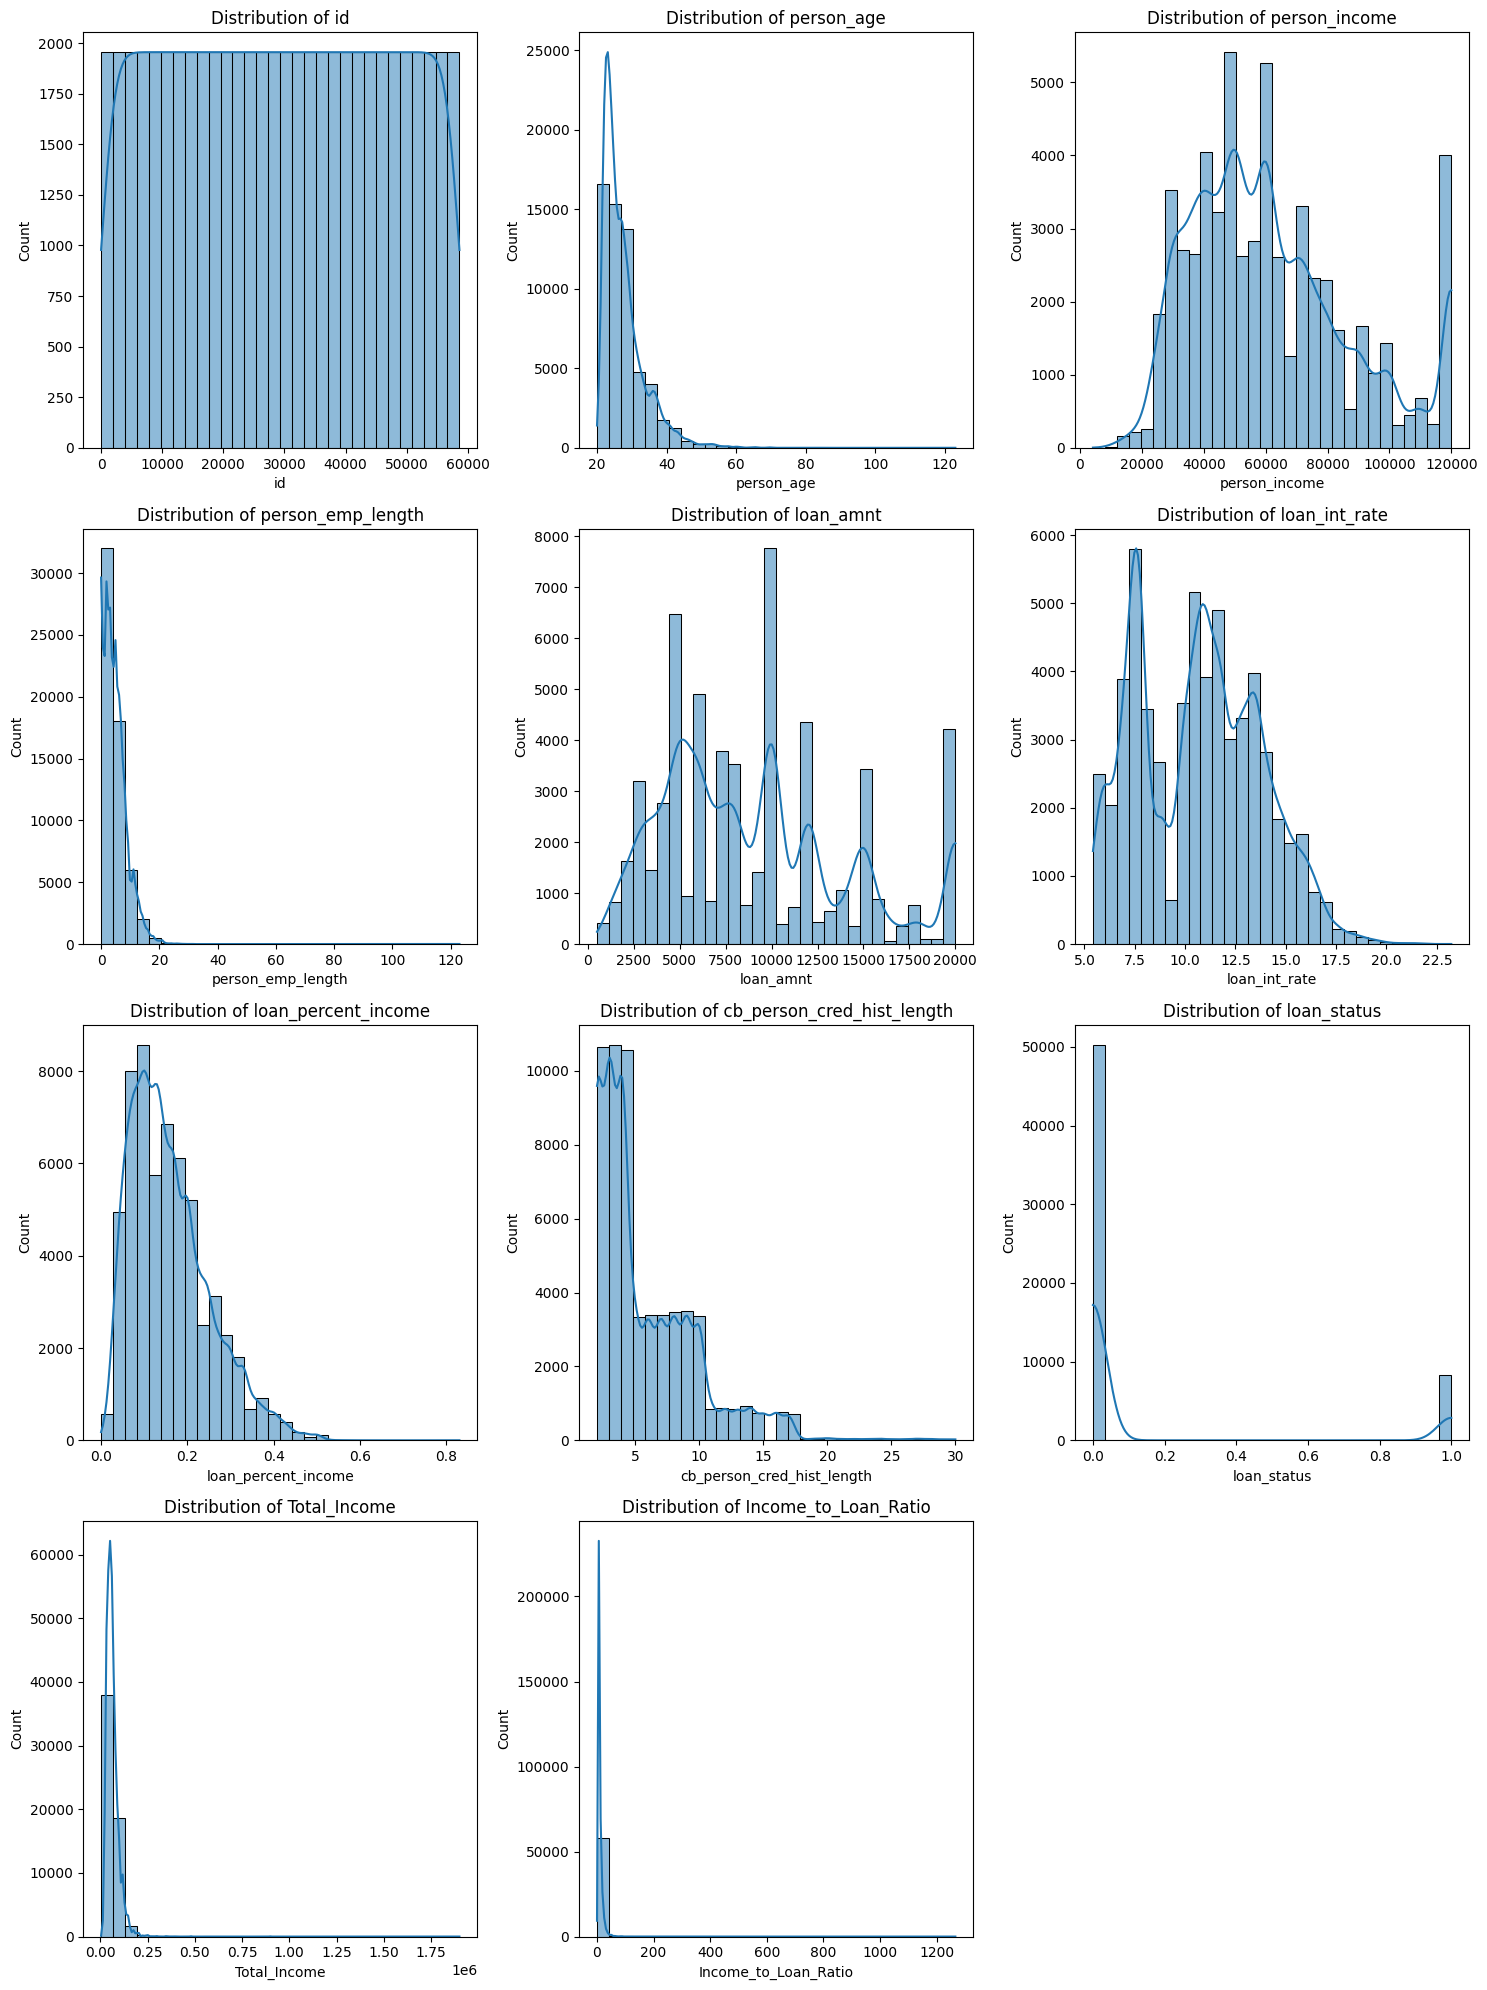

In [11]:
# Visualize data
plot_distributions(train_df)


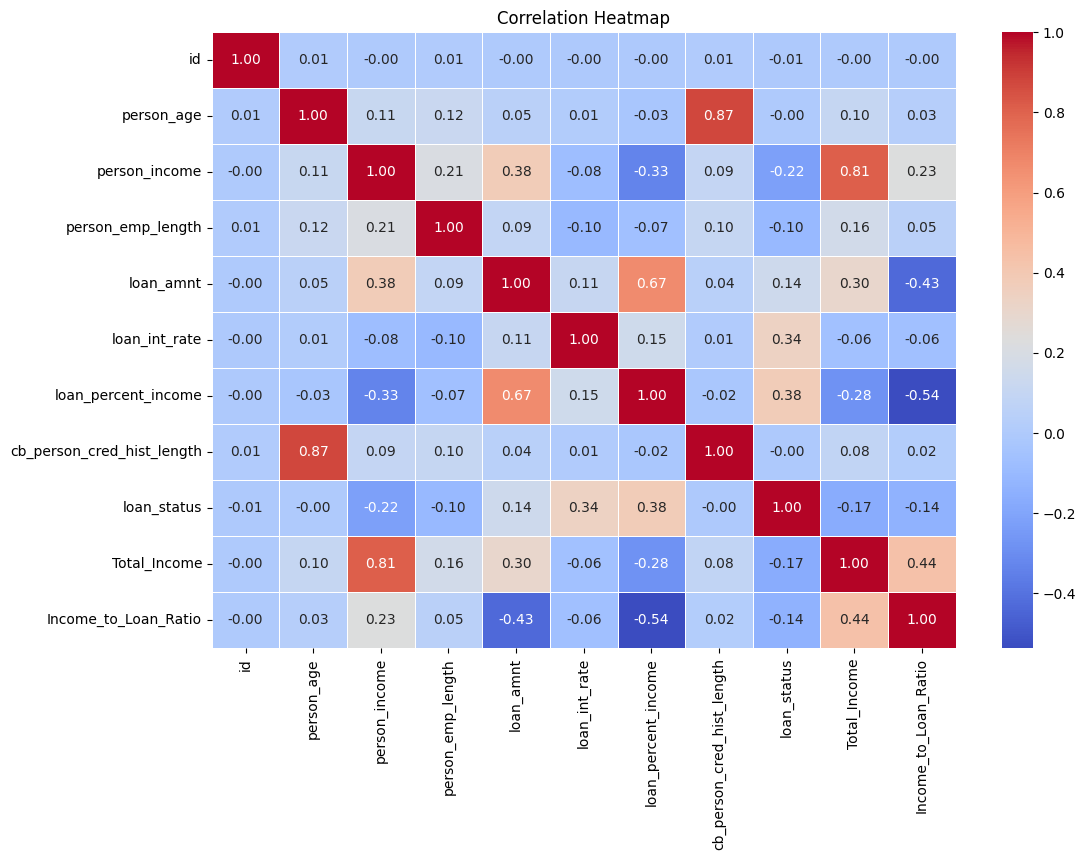

In [12]:
plot_correlation_heatmap(train_df)


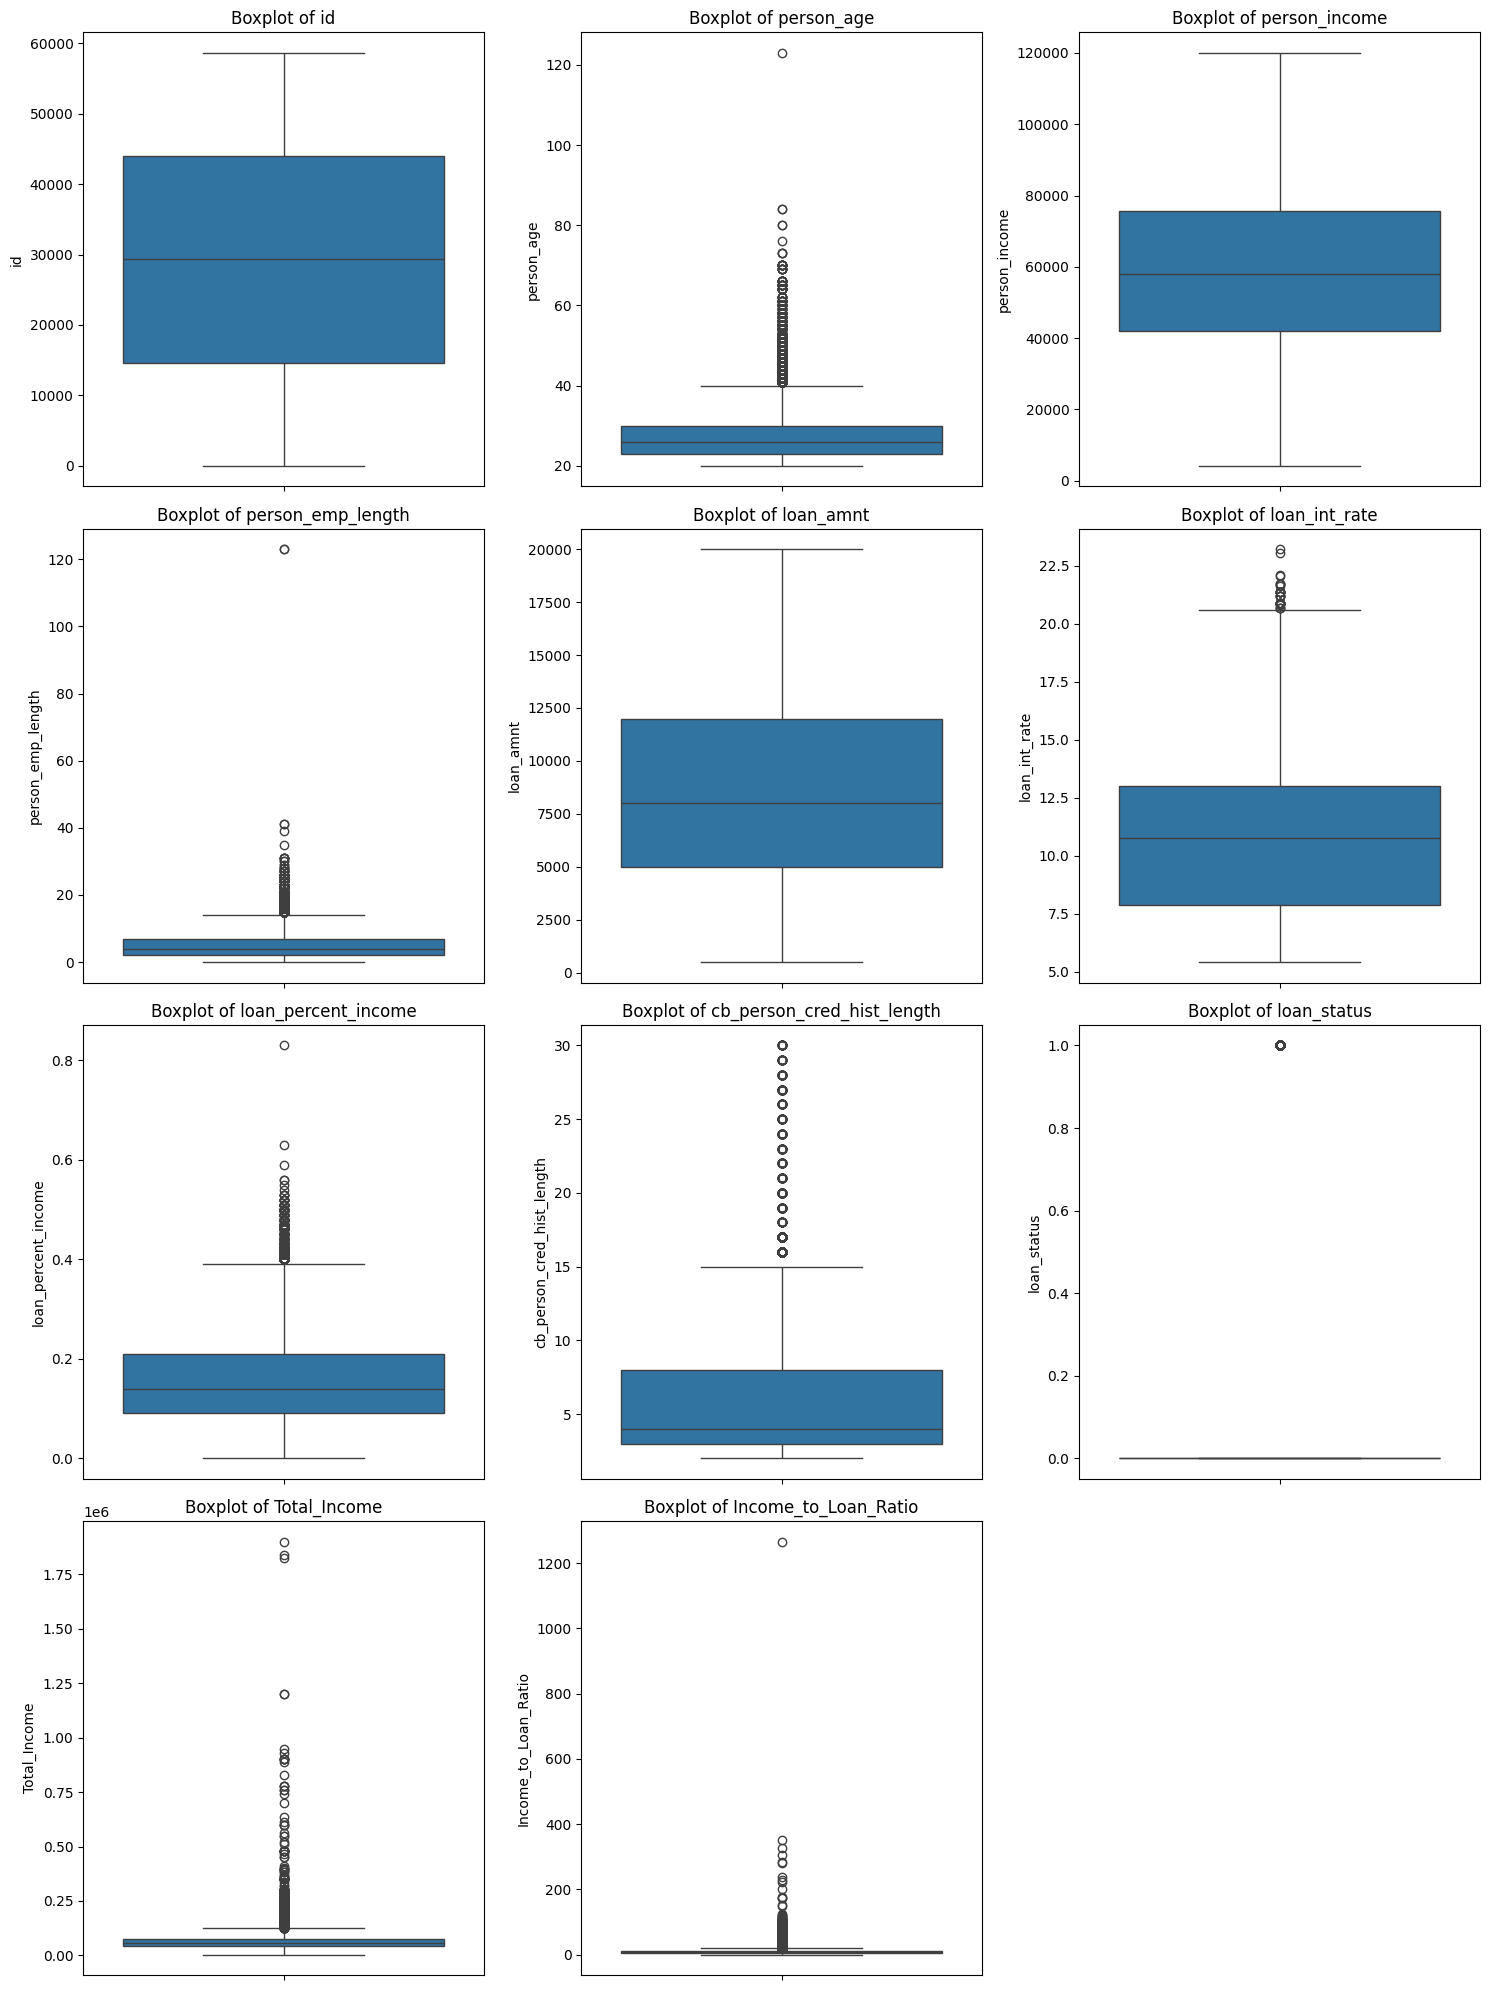

In [13]:
plot_boxplots(train_df)


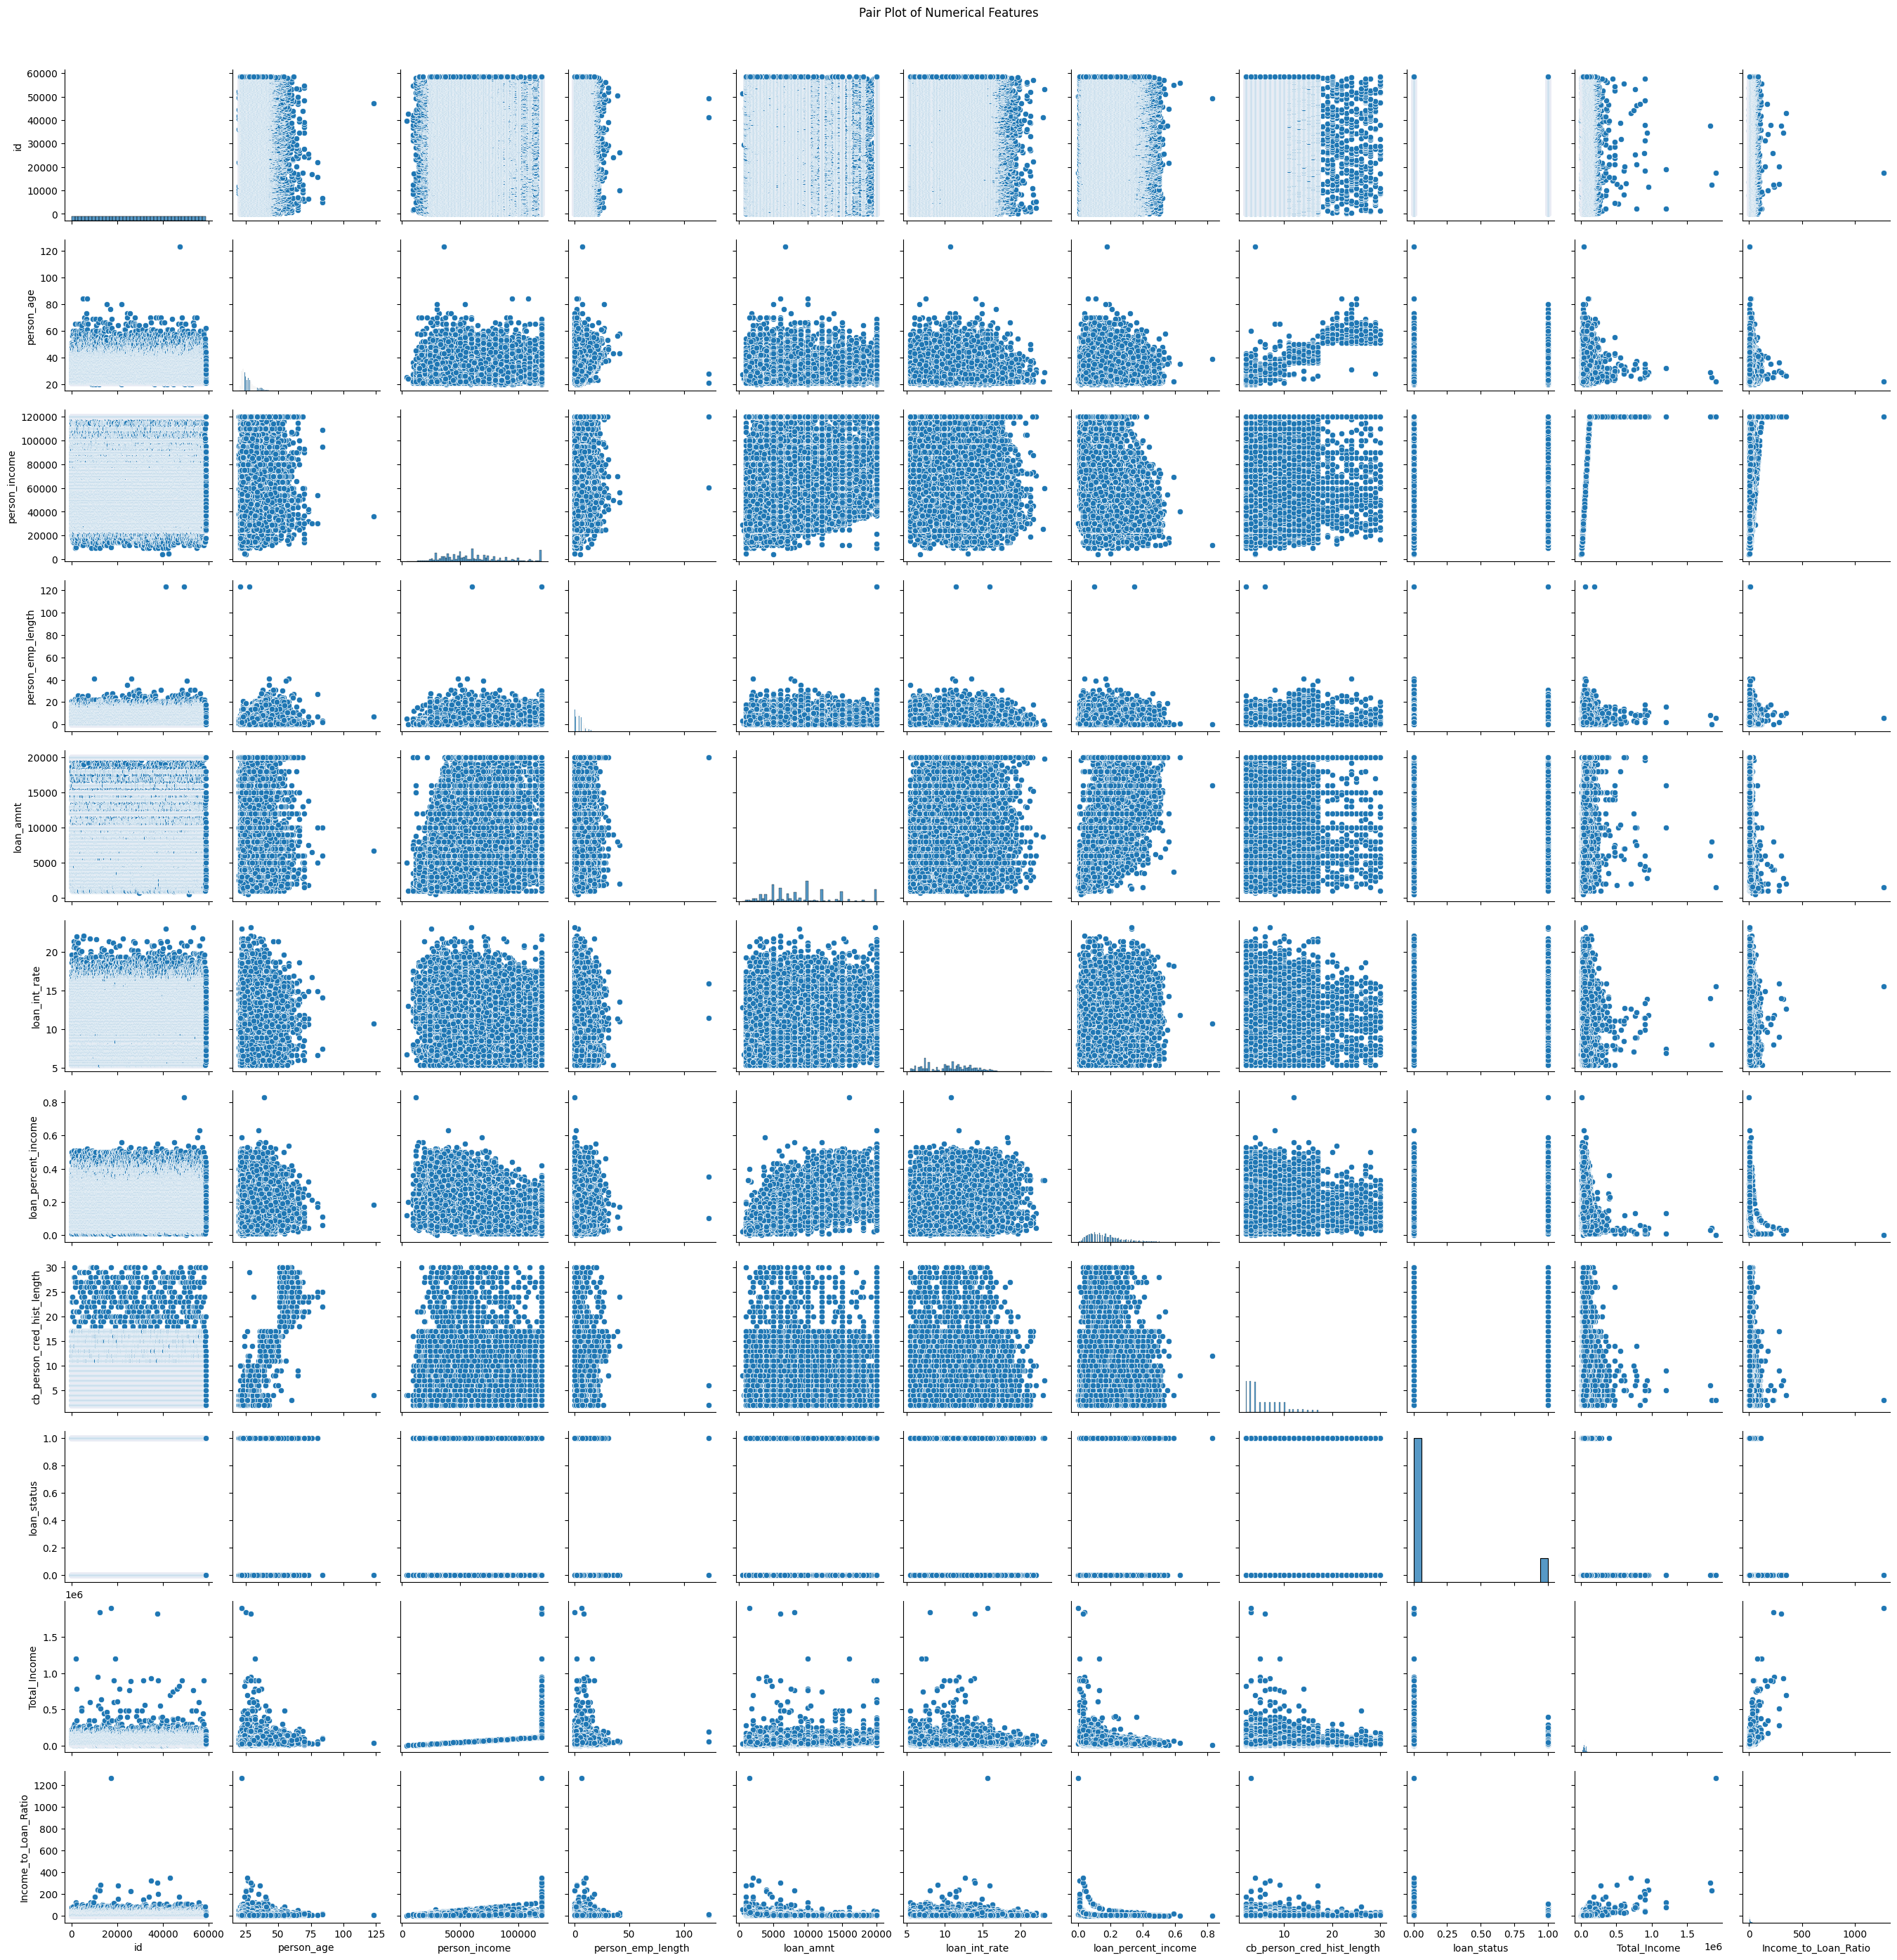

In [14]:
plot_pairplot(train_df)

In [15]:
# Preparing data for the model
def prepare_data(train_df, test_df):
    X = train_df.drop(['loan_status', 'id'], axis=1)
    y = train_df['loan_status']
    cat_columns = X.select_dtypes(include=['object']).columns.tolist()
    num_columns = X.select_dtypes(exclude=['object']).columns.tolist()
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', PowerTransformer(method='yeo-johnson'))
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_columns),
            ('cat', categorical_transformer, cat_columns)
        ]
    )
    
    feature_selector = SelectKBest(score_func=mutual_info_classif, k=10)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val, preprocessor, feature_selector


In [16]:
# Data split
X_train, X_val, y_train, y_val, preprocessor, feature_selector = prepare_data(train_df, test_df)


In [17]:
# Model Creation and Hyperparameter Tuning
def create_model():
    return RandomForestClassifier(random_state=42)


In [18]:
def tune_hyperparameters(preprocessor, feature_selector, X_train, y_train):
    model = create_model()
    full_pipeline = make_pipeline(
        preprocessor,
        feature_selector,
        SMOTE(random_state=42),
        model
    )
    
    param_grid = {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [10, 20, None],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4]
    }
    
    random_search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    
    best_model = random_search.fit(X_train, y_train)
    return best_model


In [19]:
# Tune and train the model
best_model = tune_hyperparameters(preprocessor, feature_selector, X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Accuracy Score: 0.918663142637906

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     10087
         1.0       0.69      0.76      0.72      1642

    accuracy                           0.92     11729
   macro avg       0.83      0.85      0.84     11729
weighted avg       0.92      0.92      0.92     11729



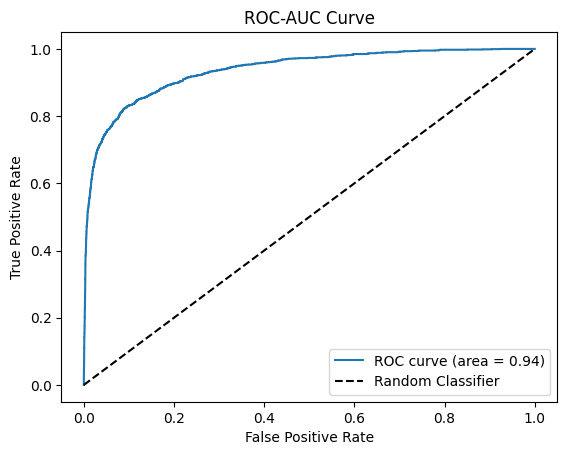

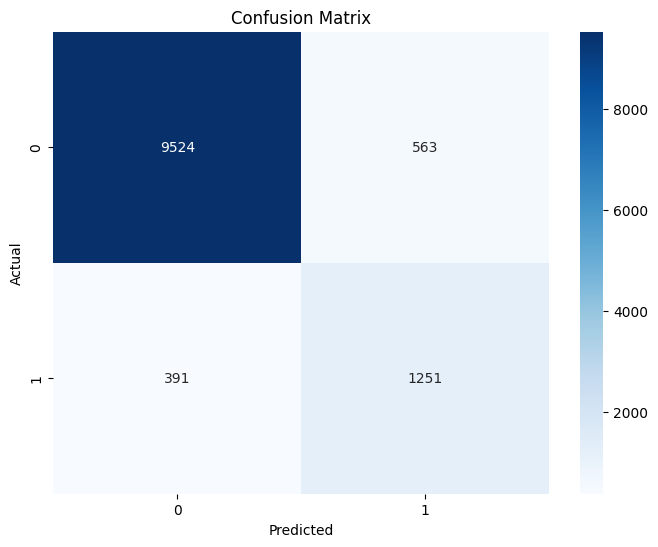

In [20]:
# Evaluate model performance
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    print("Accuracy Score:", accuracy_score(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    
    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_proba))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the model
evaluate_model(best_model, X_val, y_val)

In [21]:

def plot_feature_importance(model, X_train):
    # Get the best pipeline from the RandomizedSearchCV object
    best_pipeline = model.best_estimator_
    
    # Access the ColumnTransformer step
    preprocessor = best_pipeline.named_steps['columntransformer']
    
    # Extract the names of numerical and categorical columns
    num_features = X_train.select_dtypes(exclude='object').columns.tolist()
    
    # OneHotEncoder creates new feature names for categorical columns
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(
        X_train.select_dtypes(include='object').columns.tolist()
    )
    
    # Combine numerical and one-hot encoded categorical features
    all_features = np.concatenate([num_features, cat_features])
    
    # Access the SelectKBest step in the pipeline to get the mask of selected features
    feature_selector = best_pipeline.named_steps['selectkbest']
    selected_features_mask = feature_selector.get_support()  # Boolean mask of selected features
    
    # Get the feature names corresponding to the selected features
    selected_features = all_features[selected_features_mask]
    
    # Get the RandomForestClassifier step
    rf_model = best_pipeline.named_steps['randomforestclassifier']
    
    # Get feature importances from the random forest model
    feature_importances = rf_model.feature_importances_
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    # Plot the selected features and their importances
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance for Selected Features')
    plt.bar(range(len(selected_features)), feature_importances[sorted_idx], align='center')
    plt.xticks(range(len(selected_features)), selected_features[sorted_idx], rotation=90)
    plt.tight_layout()
    plt.show()



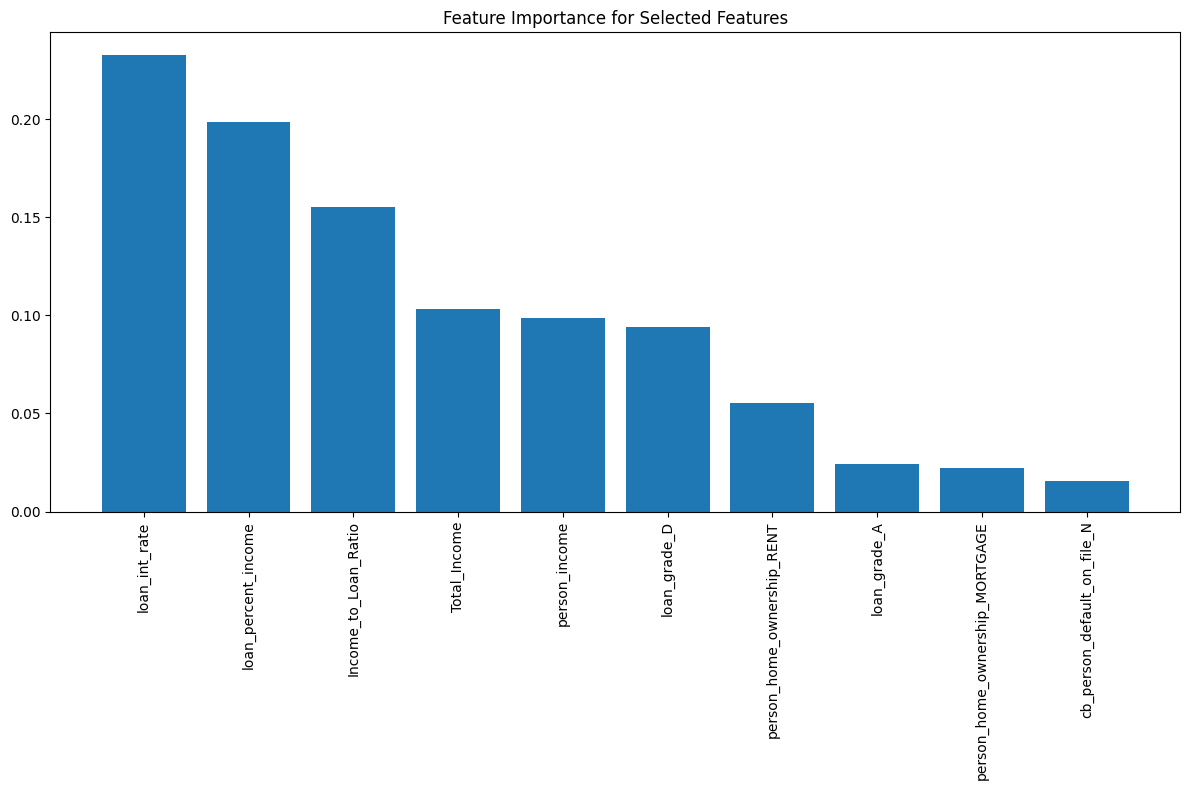

In [22]:
# Plot feature importance
plot_feature_importance(best_model, X_train)


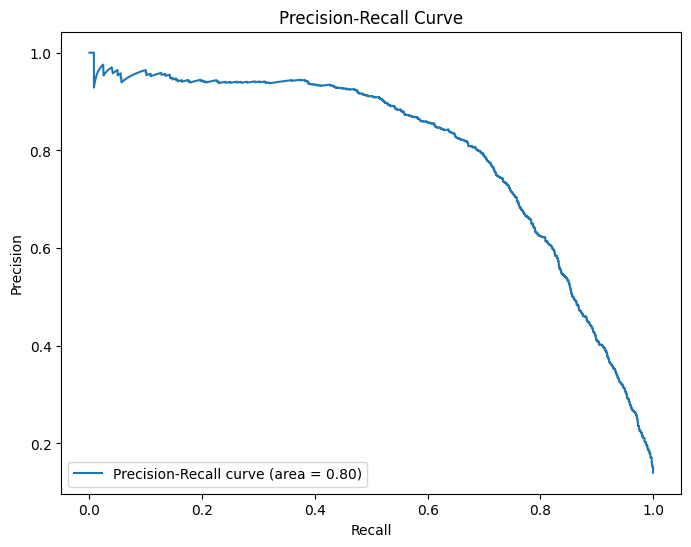

In [23]:
# Precision-recall curve plot
def plot_precision_recall_curve(model, X_val, y_val):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    avg_precision = average_precision_score(y_val, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Plot precision-recall curve
plot_precision_recall_curve(best_model, X_val, y_val)

In [ ]:
# SHAP value plots
def plot_shap_values(model, X_val):
    best_pipeline = model.best_estimator_
    X_val_transformed = best_pipeline.named_steps['columntransformer'].transform(X_val)
    rf_model = best_pipeline.named_steps['randomforestclassifier']
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_val_transformed)
    plt.figure()
    shap.summary_plot(shap_values, X_val_transformed, plot_type="bar")
    plt.show()

def plot_shap_summary(model, X_val):
    best_pipeline = model.best_estimator_
    X_val_transformed = best_pipeline.named_steps['columntransformer'].transform(X_val)
    rf_model = best_pipeline.named_steps['randomforestclassifier']
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_val_transformed)
    plt.figure()
    shap.summary_plot(shap_values, X_val_transformed)
    plt.show()

# Plot SHAP values
plot_shap_values(best_model, X_val)
plot_shap_summary(best_model, X_val)